<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/bayes_stats/funnel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we explore the "funnel of hell". This refers to a posterior in which
the mean and variance of a variable are highly correlated, and have a funnel
shape. (The term "funnel of hell" is from [this blog post](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/) by  Thomas Wiecki.)

We illustrate this using a hierarchical Bayesian model for inferring Gaussian means, fit to synthetic data, similar to 8 schools (except we vary the same size and fix the variance). This code is based on [this notebook](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2017/tutorials/aux8_mcmc_tips.html) from Justin Bois.

In [33]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
!pip install pymc3==3.8
import pymc3 as pm
pm.__version__

# The arviz package (https://github.com/arviz-devs/arviz) can be used to make various plots
# of posterior samples generated by any algorithm. 
!pip install arviz
import arviz as az

In [0]:
import math
import pickle

import numpy as np
import pandas as pd
import scipy.stats as st
import theano.tensor as tt
import theano

In [55]:
np.random.seed(0)
# Specify parameters for random data
mu_val = 8
tau_val = 3
sigma_val = 10
n_groups = 10

# Generate number of replicates for each repeat
n = np.random.randint(low=3, high=10, size=n_groups, dtype=int)
print(n)
print(sum(n))

[7 8 3 6 6 6 4 6 8 5]
59


In [57]:
# Generate data set
mus = np.zeros(n_groups)
x = np.array([])
for i in range(n_groups):
  mus[i] = np.random.normal(mu_val, tau_val)
  samples = np.random.normal(mus[i], sigma_val, size=n[i])
  x = np.append(x, samples)

print(x.shape)

group_ind = np.concatenate([[i]*n_val for i, n_val in enumerate(n)])

(59,)


In [58]:

with pm.Model() as centered_model:
    # Hyperpriors
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=2.5)
    log_tau = pm.Deterministic('log_tau', tt.log(tau))

    # Prior on theta
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=n_groups)
    
    # Likelihood
    x_obs = pm.Normal('x_obs',
                       mu=theta[group_ind],
                       sd=sigma_val,
                       observed=x)


np.random.seed(0)
with centered_model:
    centered_trace = pm.sample(10000, chains=2)
    
pm.summary(centered_trace).round(2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu]
Sampling chain 1, 264 divergences: 100%|██████████| 10500/10500 [00:22<00:00, 466.29it/s]
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 354 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7215778082983005, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,5.96,1.55,2.91,8.74,0.03,0.02,2268.0,2251.0,2214.0,1701.0,1.00
theta[0],8.44,2.89,3.67,14.33,0.09,0.06,1110.0,1110.0,1035.0,1369.0,1.01
theta[1],7.04,2.31,2.66,11.47,0.05,0.04,2064.0,2064.0,1866.0,1732.0,1.00
theta[2],6.43,2.67,1.30,11.78,0.03,0.02,6488.0,6310.0,5231.0,8972.0,1.00
theta[3],6.66,2.37,2.31,11.41,0.04,0.03,3602.0,3483.0,3209.0,8466.0,1.00
theta[4],6.59,2.36,2.28,11.36,0.04,0.03,4276.0,3913.0,3849.0,2989.0,1.00
theta[5],4.93,2.56,-0.29,9.32,0.05,0.04,2424.0,2413.0,2221.0,4470.0,1.00
theta[6],4.78,2.74,-0.75,9.60,0.04,0.03,3725.0,3725.0,3466.0,8156.0,1.01
theta[7],5.52,2.39,0.83,10.01,0.04,0.02,4459.0,4459.0,4173.0,9834.0,1.01
theta[8],4.05,2.68,-1.09,8.70,0.08,0.06,1103.0,1103.0,1098.0,1174.0,1.00


In [59]:
with pm.Model() as noncentered_model:
    # Hyperpriors
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=2.5)
    log_tau = pm.Deterministic('log_tau', tt.log(tau))
    
    # Prior on theta
    #theta = pm.Normal('theta', mu=mu, sd=tau, shape=n_trials)
    var_theta = pm.Normal('var_theta', mu=0, sd=1, shape=n_groups)
    theta = pm.Deterministic('theta', mu + var_theta * tau)
    
    # Likelihood
    x_obs = pm.Normal('x_obs',
                       mu=theta[group_ind],
                       sd=sigma_val,
                       observed=x)
    
np.random.seed(0)
with noncentered_model:
    noncentered_trace = pm.sample(1000, chains=2)
    
pm.summary(noncentered_trace).round(2)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [var_theta, tau, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:02<00:00, 530.27it/s]
The acceptance probability does not match the target. It is 0.8970025283836794, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,5.95,1.49,3.21,9.01,0.05,0.04,912.0,912.0,929.0,659.0,1.0
var_theta[0],0.80,0.92,-1.00,2.42,0.02,0.02,1624.0,1585.0,1652.0,1371.0,1.0
var_theta[1],0.36,0.85,-1.25,1.95,0.02,0.02,2020.0,864.0,2016.0,1303.0,1.0
var_theta[2],0.15,0.89,-1.51,1.80,0.02,0.02,1913.0,843.0,1914.0,1351.0,1.0
var_theta[3],0.26,0.86,-1.43,1.76,0.02,0.02,1873.0,1053.0,1889.0,1452.0,1.0
var_theta[4],0.20,0.88,-1.43,1.88,0.02,0.02,1593.0,897.0,1623.0,1371.0,1.0
var_theta[5],-0.35,0.92,-1.95,1.47,0.02,0.03,2471.0,606.0,2458.0,853.0,1.0
var_theta[6],-0.40,0.93,-2.11,1.40,0.02,0.02,1869.0,928.0,1867.0,1280.0,1.0
var_theta[7],-0.16,0.87,-1.65,1.60,0.02,0.02,2194.0,864.0,2197.0,1338.0,1.0
var_theta[8],-0.68,0.90,-2.43,0.94,0.02,0.02,2132.0,1394.0,2150.0,1451.0,1.0


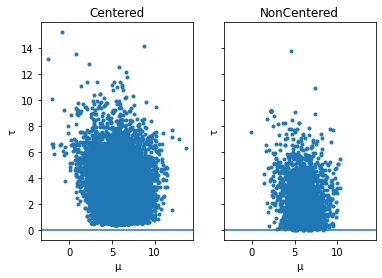

In [69]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
x = pd.Series(centered_trace['mu'], name='mu')
y  = pd.Series(centered_trace['tau'], name='tau')
axs[0].plot(x, y, '.');
axs[0].set(title='Centered', xlabel='µ', ylabel='τ');
axs[0].axhline(0.01)

x = pd.Series(noncentered_trace['mu'], name='mu')
y  = pd.Series(noncentered_trace['tau'], name='tau')
axs[1].plot(x, y, '.');
axs[1].set(title='NonCentered', xlabel='µ', ylabel='τ');
axs[1].axhline(0.01)

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

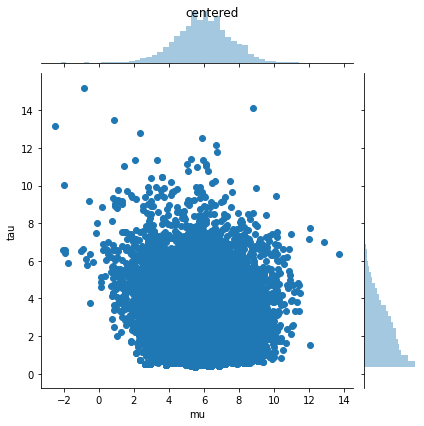

In [71]:
x = pd.Series(centered_trace['mu'], name='mu')
y  = pd.Series(centered_trace['tau'], name='tau')
g = sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle('centered')
plt.show()

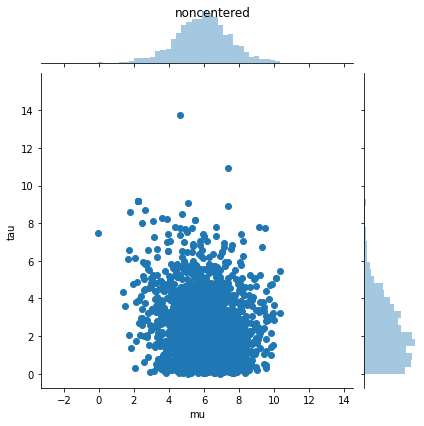

In [70]:
x = pd.Series(noncentered_trace['mu'], name='mu')
y  = pd.Series(noncentered_trace['tau'], name='tau')
g = sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle('noncentered')
plt.show()

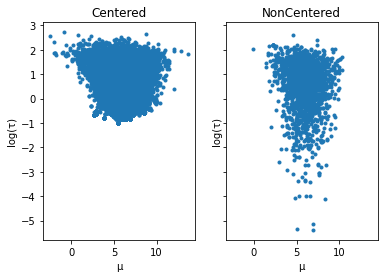

In [66]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
x = pd.Series(centered_trace['mu'], name='mu')
y  = pd.Series(centered_trace['log_tau'], name='log_tau')
axs[0].plot(x, y, '.');
axs[0].set(title='Centered', xlabel='µ', ylabel='log(τ)');

x = pd.Series(noncentered_trace['mu'], name='mu')
y  = pd.Series(noncentered_trace['log_tau'], name='log_tau')
axs[1].plot(x, y, '.');
axs[1].set(title='NonCentered', xlabel='µ', ylabel='log(τ)');

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

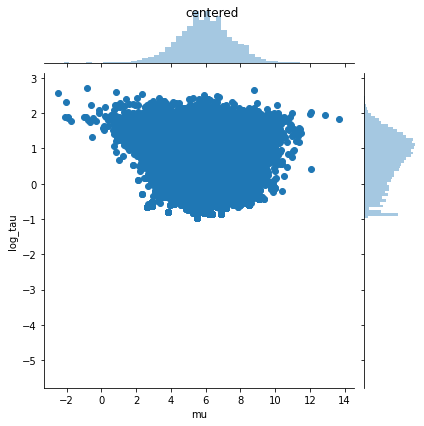

In [67]:
#https://seaborn.pydata.org/generated/seaborn.jointplot.html

x = pd.Series(centered_trace['mu'], name='mu')
y  = pd.Series(centered_trace['log_tau'], name='log_tau')
g = sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle('centered')
plt.show()

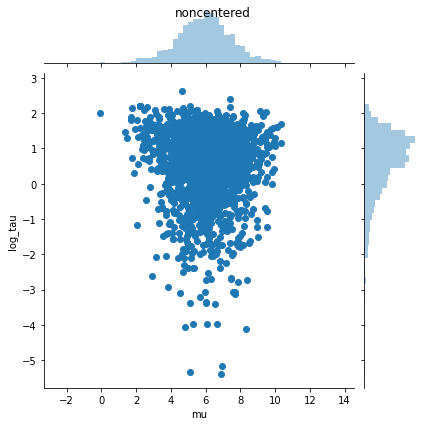

In [68]:
x = pd.Series(noncentered_trace['mu'], name='mu')
y  = pd.Series(noncentered_trace['log_tau'], name='log_tau')
g = sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle('noncentered')
plt.show()

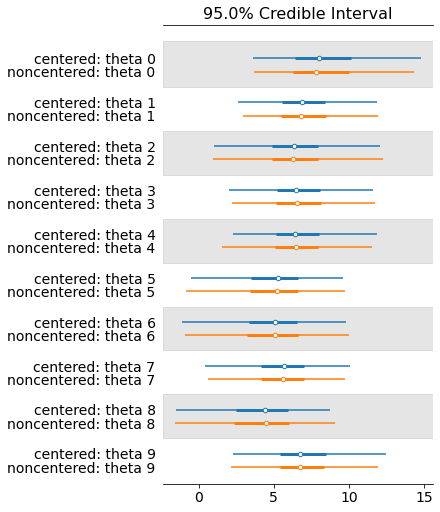

In [72]:
az.plot_forest([centered_trace, noncentered_trace], model_names=['centered', 'noncentered'],
               var_names="theta",
               combined=True, credible_interval=0.95);